# **Regression with Decision Trees**

In [1]:
# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/home/baobu/spark-3.5.1-bin-hadoop3"

## Create a SparkSession in Python

In [2]:
# start pyspark
# !pip install findspark
import findspark
findspark.init()

In [3]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local")\
          .appName("Low-level Decision Tree")\
          .config("spark.some.config.option", "some-value")\
          .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
25/05/10 23:39:49 WARN Utils: Your hostname, LAPTOP-2K5E710T resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/05/10 23:39:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/10 23:39:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
sc = spark.sparkContext
# sc.setCheckpointDir("checkpoint")

## Low-Level Operations

### Import

In [5]:
from pyspark.sql import functions as f
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import math
import random

### 1. Read data

In [6]:
def get_data(value):
    try:
        return float(value)
    except ValueError:
        return value

In [7]:
lines = sc.textFile("nyc-taxi-trip-duration/train/train.csv")
header = lines.first()
data = lines.filter(lambda x: x != header)
parsedData = data.map(\
lambda line: [get_data(x) for x in line.split(",")])

In [8]:
def print_data(data):
    for i in range(5):
        print(data[i])
print_data(parsedData.take(5))

['id2875421', 2.0, '2016-03-14 17:24:55', '2016-03-14 17:32:30', 1.0, -73.9821548461914, 40.76793670654297, -73.96463012695312, 40.765602111816406, 'N', 455.0]
['id2377394', 1.0, '2016-06-12 00:43:35', '2016-06-12 00:54:38', 1.0, -73.98041534423828, 40.738563537597656, -73.99948120117188, 40.73115158081055, 'N', 663.0]
['id3858529', 2.0, '2016-01-19 11:35:24', '2016-01-19 12:10:48', 1.0, -73.9790267944336, 40.763938903808594, -74.00533294677734, 40.710086822509766, 'N', 2124.0]
['id3504673', 2.0, '2016-04-06 19:32:31', '2016-04-06 19:39:40', 1.0, -74.01004028320312, 40.719970703125, -74.01226806640625, 40.70671844482422, 'N', 429.0]
['id2181028', 2.0, '2016-03-26 13:30:55', '2016-03-26 13:38:10', 1.0, -73.97305297851562, 40.793209075927734, -73.9729232788086, 40.78252029418945, 'N', 435.0]


### 2. Data preprocessing:

- Kiểm tra giá trị NULL.

In [9]:
num_null_rows = parsedData.filter(lambda row: None in row).count()
print(f"Số dòng chứa NULL: {num_null_rows}")

Số dòng chứa NULL: 0


Data không chứa giá trị NULL.

- Kiểm tra trùng lặp.

In [10]:
rdd = parsedData.map(lambda x: tuple(x))
has_duplicates = rdd.count() != rdd.distinct().count()
print("Có trùng lặp:", has_duplicates)


Có trùng lặp: False


Data không chứa dòng trùng lặp.

- Chuyển các cột categorical thành cột số.
    - `store_and_fwd_flag`: chuyển thành numeric bằng LabelEncoder.
    - `pickup_datetime` / `dropoff_datetime`: tách ra tháng, ngày trong tuần và giờ cụ thể (vì 3 mốc thời gian này đa số sẽ có 1 đặc trưng cụ thể).

In [11]:
def encode_categorical_features(categorical_col, value):
    value_to_index = {value: idx for idx, value in enumerate(set(categorical_col))}
    return [value_to_index.get(value, -1)]

In [12]:
unique_values_store_col = parsedData.map(lambda row: row[-2]).distinct().collect()
parsedData = parsedData.map(lambda row: row[:-1] + encode_categorical_features(unique_values_store_col, row[-2]) + row[-1:])

In [13]:
def extract_datetime_features(datetime_col):
    try:
        dt = datetime.strptime(datetime_col, "%Y-%m-%d %H:%M:%S")
        month = dt.month
        weekday = dt.isoweekday() % 7 + 1
        hour = dt.hour
        return [month, weekday, hour]
    except ValueError:
        return [None, None, None]

In [14]:
parsedData = parsedData.map(lambda row: row[:-1] + extract_datetime_features(row[2]) + row[-1:])

In [15]:
print_data(parsedData.take(5))

['id2875421', 2.0, '2016-03-14 17:24:55', '2016-03-14 17:32:30', 1.0, -73.9821548461914, 40.76793670654297, -73.96463012695312, 40.765602111816406, 'N', 0, 3, 2, 17, 455.0]
['id2377394', 1.0, '2016-06-12 00:43:35', '2016-06-12 00:54:38', 1.0, -73.98041534423828, 40.738563537597656, -73.99948120117188, 40.73115158081055, 'N', 0, 6, 1, 0, 663.0]
['id3858529', 2.0, '2016-01-19 11:35:24', '2016-01-19 12:10:48', 1.0, -73.9790267944336, 40.763938903808594, -74.00533294677734, 40.710086822509766, 'N', 0, 1, 3, 11, 2124.0]
['id3504673', 2.0, '2016-04-06 19:32:31', '2016-04-06 19:39:40', 1.0, -74.01004028320312, 40.719970703125, -74.01226806640625, 40.70671844482422, 'N', 0, 4, 4, 19, 429.0]
['id2181028', 2.0, '2016-03-26 13:30:55', '2016-03-26 13:38:10', 1.0, -73.97305297851562, 40.793209075927734, -73.9729232788086, 40.78252029418945, 'N', 0, 3, 7, 13, 435.0]


- Xử lý các giá trị bất hợp lý trong trip_duration 

In [16]:
trip_duration_col = parsedData.map(lambda row: row[-1]).collect()

In [17]:
print("Min:", np.min(trip_duration_col))
print("Max:", np.max(trip_duration_col))
print("Mean:", np.mean(trip_duration_col))
print("Std:", np.std(trip_duration_col))
print("25%:", np.percentile(trip_duration_col, 25))
print("50% (Median):", np.median(trip_duration_col))
print("75%:", np.percentile(trip_duration_col, 75))

Min: 1.0
Max: 3526282.0
Mean: 959.4922729603659
Std: 5237.429929188888
25%: 397.0
50% (Median): 662.0
75%: 1075.0


- Một vài giá trị trip_duration vô lý: 
    - $min = 1s$ (Vì ko thể có chuyến taxi nào chỉ 1s)
    - $max = 3,526,282s \approx 40 ngày$: không thể có chuyến taxi kéo dài hơn cả tháng.
- Ngoài ra, các các giá trị phân vị thứ 1 và thứ 3 cách rất xa giá trị min và max, chứng tỏ có nhiều giá trị cực thấp/cực thấp bất thường.

$\Rightarrow$ Ước lượng khoảng giá trị hợp lý cho 1 cuốc taxi: 60s (1 phút) đến 3,600s (1 giờ) $\rightarrow$ Loại bỏ các giá trị nằm ngoài khoảng.

- Xử lý phân phối cho `trip_duration`

In [18]:
print("Số mẫu trước khi loại bỏ:", parsedData.count())
parsedData = parsedData.filter(lambda row: (row[-1] >= 60) & (row[-1] <= 3600))
print("Số mẫu sau khi loại bỏ giá trị bất hợp lý:", parsedData.count())

Số mẫu trước khi loại bỏ: 1458644


Số mẫu sau khi loại bỏ giá trị bất hợp lý: 1437732


In [19]:
trip_duration_col = parsedData.map(lambda row: row[-1]).collect()

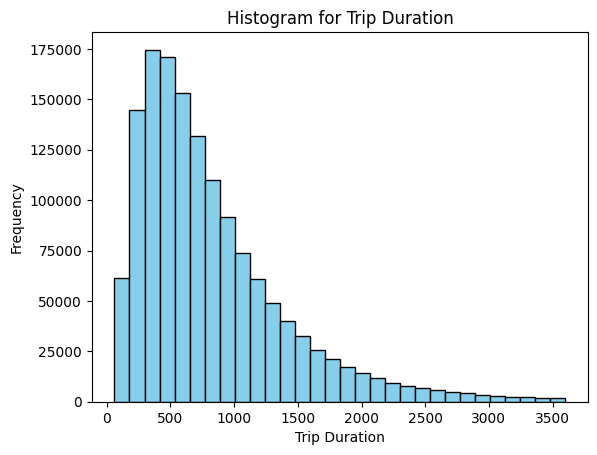

In [20]:
# Plotting a basic histogram
plt.hist(trip_duration_col, bins=30, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.title('Histogram for Trip Duration')
 
# Display the plot
plt.show()

Dữ liệu bị lệch phải $\Rightarrow$ Em dùng Log Tranformation để cân bằng lại.

In [21]:
parsedData = parsedData.map(lambda row: row[:-1] + [float(np.log1p(row[-1]))])

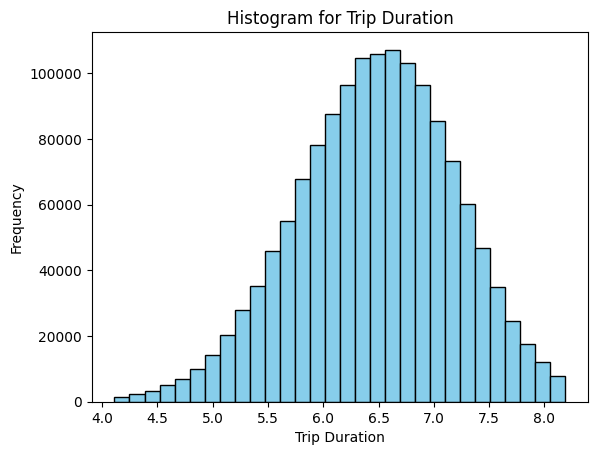

In [22]:
trip_duration_col = parsedData.map(lambda row: row[-1]).collect()
# Plotting a basic histogram
plt.hist(trip_duration_col, bins=30, color='skyblue', edgecolor='black')
 
# Adding labels and title
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.title('Histogram for Trip Duration')
 
# Display the plot
plt.show()

Phân phối vẫn hơi lệch trái nhưng em tạm chấp nhận.

In [23]:
print_data(parsedData.take(5))

['id2875421', 2.0, '2016-03-14 17:24:55', '2016-03-14 17:32:30', 1.0, -73.9821548461914, 40.76793670654297, -73.96463012695312, 40.765602111816406, 'N', 0, 3, 2, 17, 6.1224928095143865]
['id2377394', 1.0, '2016-06-12 00:43:35', '2016-06-12 00:54:38', 1.0, -73.98041534423828, 40.738563537597656, -73.99948120117188, 40.73115158081055, 'N', 0, 6, 1, 0, 6.498282149476434]
['id3858529', 2.0, '2016-01-19 11:35:24', '2016-01-19 12:10:48', 1.0, -73.9790267944336, 40.763938903808594, -74.00533294677734, 40.710086822509766, 'N', 0, 1, 3, 11, 7.661527081358517]
['id3504673', 2.0, '2016-04-06 19:32:31', '2016-04-06 19:39:40', 1.0, -74.01004028320312, 40.719970703125, -74.01226806640625, 40.70671844482422, 'N', 0, 4, 4, 19, 6.063785208687608]
['id2181028', 2.0, '2016-03-26 13:30:55', '2016-03-26 13:38:10', 1.0, -73.97305297851562, 40.793209075927734, -73.9729232788086, 40.78252029418945, 'N', 0, 3, 7, 13, 6.077642243349034]


25/05/10 23:43:17 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 14 (TID 69): Attempting to kill Python Worker


### 3. Create a RDD with record (features as list, label)

- Lấy các giá trị số.

In [24]:
numeric_data = parsedData.map(lambda row: [x for x in row if isinstance(x, (int, float))])
print_data(numeric_data.take(5))

[2.0, 1.0, -73.9821548461914, 40.76793670654297, -73.96463012695312, 40.765602111816406, 0, 3, 2, 17, 6.1224928095143865]
[1.0, 1.0, -73.98041534423828, 40.738563537597656, -73.99948120117188, 40.73115158081055, 0, 6, 1, 0, 6.498282149476434]
[2.0, 1.0, -73.9790267944336, 40.763938903808594, -74.00533294677734, 40.710086822509766, 0, 1, 3, 11, 7.661527081358517]
[2.0, 1.0, -74.01004028320312, 40.719970703125, -74.01226806640625, 40.70671844482422, 0, 4, 4, 19, 6.063785208687608]
[2.0, 1.0, -73.97305297851562, 40.793209075927734, -73.9729232788086, 40.78252029418945, 0, 3, 7, 13, 6.077642243349034]


Cột giá trị tương ứng lần lượt là: [`vendor_id`, `passenger_count`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`, `store_and_fwd_flag_encode`, `pickup_month`, `pickup_weekday`, `pickup_hour`, `trip_duration`]

- Tạo data rdd dạng tuple.

In [25]:
rdd_data = numeric_data.map(lambda cols: (cols[:-1], cols[-1]))

In [26]:
print_data(rdd_data.take(5))

([2.0, 1.0, -73.9821548461914, 40.76793670654297, -73.96463012695312, 40.765602111816406, 0, 3, 2, 17], 6.1224928095143865)
([1.0, 1.0, -73.98041534423828, 40.738563537597656, -73.99948120117188, 40.73115158081055, 0, 6, 1, 0], 6.498282149476434)
([2.0, 1.0, -73.9790267944336, 40.763938903808594, -74.00533294677734, 40.710086822509766, 0, 1, 3, 11], 7.661527081358517)
([2.0, 1.0, -74.01004028320312, 40.719970703125, -74.01226806640625, 40.70671844482422, 0, 4, 4, 19], 6.063785208687608)
([2.0, 1.0, -73.97305297851562, 40.793209075927734, -73.9729232788086, 40.78252029418945, 0, 3, 7, 13], 6.077642243349034)


### 4. Implement Decision Tree Regression Model

- Cài đặt bằng numpy.

In [27]:
def get_variance(data):
    n = len(data)
    mean = sum(data) / n
    variance = sum((x - mean) ** 2 for x in data) / n
    return variance

In [28]:
def get_mean(data):
    return sum(data) / len(data)

In [29]:
def find_best_all_splits(X, y, num_bins=10):

    best_variance = float("inf")
    best_split = None
    best_feature_idx = None

    num_features = len(X[0])
    num_samples = len(X)

    for feature_idx in range(num_features):
        # splits = sorted(set(X[:,feature_idx]))

        percentiles = np.percentile(X[:,feature_idx], np.linspace(0, 100, num_bins + 2)[1:-1])
        splits = sorted(set(percentiles))  # tránh duplicate

        for split in splits:
            y_left = y[X[:,feature_idx] <= split]
            y_right = y[X[:,feature_idx] > split]

            n_left = len(y_left)

            if not (0 < n_left < num_samples): continue
            
            left_variance = get_variance(y_left)
            right_variance = get_variance(y_right)

            current_variance = (n_left * left_variance + (num_samples - n_left) * right_variance) / num_samples
            if current_variance < best_variance:
                best_variance = current_variance
                best_split = split
                best_feature_idx = feature_idx

    return best_feature_idx, best_split, best_variance

In [30]:
def dtfit(X, y, depth=0, max_depth=None):
    X = np.array(X)
    y = np.array(y)
    if (max_depth is not None) and (depth >= max_depth):
        return {"val": float(get_mean(y))}
    
    feature_idx, split, _ = find_best_all_splits(X, y)
    
    if feature_idx is None:
        return {"val": float(get_mean(y))}

    left_mask = X[:,feature_idx] <= split
    right_mask = X[:,feature_idx] > split

    left_X = X[left_mask]
    left_y = y[left_mask]
    right_X = X[right_mask]
    right_y = y[right_mask]

    if len(left_y) == 0 or len(right_y) == 0:
        return {"val": float(get_mean(y))}

    node = {
        "index_col": feature_idx,
        "split": split,
        "val": float(get_mean(y)),
        "left": None,
        "right": None
    }

    node["left"] = dtfit(left_X, left_y, depth + 1, max_depth)
    node["right"] = dtfit(right_X, right_y, depth + 1, max_depth)    
    
    return node
    

In [31]:
def predict(tree, x):
    if "left" not in tree:
        return tree["val"]
    
    if x[tree["index_col"]] <= tree["split"]:
        return predict(tree["left"], x)
    else:
        return predict(tree["right"], x)
    
def predict_all(tree, X):
    return [predict(tree, x) for x in X]


- Đánh giá mô hình: $$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i}^2)}$$

In [32]:
def rmse(y_true, y_pred):
    y_true = np.array(y_true)   
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

- Một vài ví dụ để chạy thử.

In [33]:
train_data = [
    [1.0, 0.5],  # Features: [x1, x2]
    [2.0, 1.0],
    [3.0, 1.5],
    [4.0, 2.0],
    [5.0, 2.5]
]
train_labels = [2.1, 3.9, 6.2, 8.0, 9.8]  # y ≈ 2 * x1 + noise

X_rdd = sc.parallelize(train_data)
y_rdd = sc.parallelize(train_labels)

tree = dtfit(X_rdd.collect(), y_rdd.collect(), max_depth=3)

test_data = [
    [1.5, 0.7],  # Giá trị thật ≈ 3.0
    [4.5, 2.3]   # Giá trị thật ≈ 9.0
]
test_rdd = sc.parallelize(test_data)
test_labels = sc.parallelize([3.2, 8.8])
predictions = predict_all(tree, test_rdd.collect())

print("Dự đoán cho dữ liệu kiểm tra:", predictions)
print("Đanhh giá RMSE:", rmse(test_labels.collect(), predictions))

Dự đoán cho dữ liệu kiểm tra: [3.9, 9.8]
Đanhh giá RMSE: 0.8631338250816033


- Cài đặt cho rdd (nhưng máy em không chạy nổi :<< )

In [34]:
def get_mean_rdd(y_rdd):
    n = y_rdd.count()
    if n == 0:
        return 0
    return y_rdd.reduce(lambda x, y: x + y) / n

In [35]:
def get_variance_rdd(y_rdd):
    n = y_rdd.count()
    if n == 0:
        return 0
    
    mean = get_mean_rdd(y_rdd)
    squre_diff = y_rdd.map(lambda x: (x - mean) ** 2)
    sum_squre_diff = squre_diff.reduce(lambda x, y: x + y)
    
    return sum_squre_diff / n

In [36]:
def find_best_all_splits_rdd(X_rdd, y_rdd, num_bins=10):
    combined = X_rdd.zip(y_rdd).cache()
    # combined.checkpoint()

    best_variance = float("inf")
    best_split = None
    best_feature_idx = None

    num_features = len(X_rdd.first()) if not X_rdd.isEmpty() else 0
    num_samples = X_rdd.count()

    for feature_idx in range(num_features):
        feature_values = X_rdd.map(lambda x: x[feature_idx]).collect()
        percentiles = np.percentile(feature_values, np.linspace(0, 100, num_bins + 2)[1:-1])  # bỏ 0% và 100%
        splits = sorted(set(percentiles))  
        # splits = X_rdd.map(lambda x: x[feature_idx]).distinct().collect()
        # splits.sort()
        for split in splits:

            left_y = combined.filter(lambda x: x[0][feature_idx] <= split).map(lambda x: x[1])
            right_y = combined.filter(lambda x: x[0][feature_idx] > split).map(lambda x: x[1])
            
            n_left = left_y.count()

            if not (0 < n_left < num_samples):
                continue
                
            try:
                # Tính variance
                left_var = get_variance_rdd(left_y)
                right_var = get_variance_rdd(right_y)

                current_var = (n_left * left_var + (num_samples - n_left) * right_var) / num_samples
                
                if current_var < best_variance:
                    best_variance = current_var
                    best_split = split
                    best_feature_idx = feature_idx
                    
            except Exception as e:
                print(f"Lỗi khi tính variance: {e}")
                continue

    return best_feature_idx, best_split, best_variance

In [37]:
def dtfit_rdd(X_rdd, y_rdd, depth=0, max_depth=5):
    if (max_depth is not None) and (depth >= max_depth):
        return {"val": get_mean_rdd(y_rdd)}
    
    feature_idx, split, _ = find_best_all_splits_rdd(X_rdd, y_rdd)

    if feature_idx is None:
        return {"val": get_mean_rdd(y_rdd)}

    mask = X_rdd.map(lambda x: x[feature_idx] <= split).cache()

    left_X = X_rdd.zip(mask).filter(lambda x: x[1]).map(lambda x: x[0])
    left_y = y_rdd.zip(mask).filter(lambda x: x[1]).map(lambda x: x[0])

    right_X = X_rdd.zip(mask).filter(lambda x: not x[1]).map(lambda x: x[0]) 
    right_y = y_rdd.zip(mask).filter(lambda x: not x[1]).map(lambda x: x[0])

    node = {
        "index_col": feature_idx,
        "split": split,
        "val": get_mean_rdd(y_rdd),
        "left": None,
        "right": None
    }

    node["left"] = dtfit_rdd(left_X, left_y, depth + 1, max_depth)
    node["right"] = dtfit_rdd(right_X, right_y, depth + 1, max_depth)    
    
    return node
    

In [38]:
def predict_rdd(tree, x):
    if "left" not in tree:
        return tree["val"]
    
    if x[tree["index_col"]] <= tree["split"]:
        return predict_rdd(tree["left"], x)
    else:
        return predict_rdd(tree["right"], x)
    
def predict_all_rdd(tree, X_rdd):
    return X_rdd.map(lambda x: predict_rdd(tree, x))

- Đánh giá mô hình: $$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y_i}^2)}$$

In [39]:
def rmse_rdd(y_pred_rdd, y_rdd):
    if y_rdd.count() != y_pred_rdd.count():
        raise ValueError("y_true_rdd và y_pred_rdd phải có cùng số lượng phần tử!")
    
    squared_errors = y_rdd.zip(y_pred_rdd).map(lambda row: (row[0] - row[1]) **2)
    mse = squared_errors.mean()
    return math.sqrt(mse)

- Một vài ví dụ để chạy thử.

In [40]:
# train_data = [
#     [1.0, 0.5],  # Features: [x1, x2]
#     [2.0, 1.0],
#     [3.0, 1.5],
#     [4.0, 2.0],
#     [5.0, 2.5]
# ]
# train_labels = [2.1, 3.9, 6.2, 8.0, 9.8]  # y ≈ 2 * x1 + noise

# X_rdd = sc.parallelize(train_data)
# y_rdd = sc.parallelize(train_labels)

# tree = dtfit_rdd(X_rdd, y_rdd, max_depth=3)

# test_data = [
#     [1.5, 0.7],  # Giá trị thật ≈ 3.0
#     [4.5, 2.3]   # Giá trị thật ≈ 9.0
# ]
# test_rdd = sc.parallelize(test_data)
# test_labels = sc.parallelize([3.2, 8.8])
# predictions = predict_all_rdd(tree, test_rdd)

# print("Dự đoán cho dữ liệu kiểm tra:", predictions.collect())
# print("Đánh giá mô hình RMSE:", rmse_rdd(predictions, test_labels))

### 5. Apply low-level model in current data.

- Train - test split

Ý tưởng: gán ngẫu nhiên nhãn 'train' hoặc 'test' cho mỗi điểm dữ liệu.

In [41]:
random.seed(42)  
def assign_split(row, test_size=0.2):
    return (row, "train") if random.random() > test_size else (row, "test")

labeled_data = rdd_data.map(assign_split).cache()
train = labeled_data.filter(lambda x: x[1] == "train").map(lambda x: x[0])
validation = labeled_data.filter(lambda x: x[1] == "test").map(lambda x: x[0])
print("Số mẫu train:", train.count())
print("Số mẫu test:", validation.count())

Số mẫu train: 1150466


Số mẫu test: 287266


In [42]:
tree = dtfit(train.map(lambda x: x[0]).collect(), train.map(lambda x: x[1]).collect(), max_depth=3)


In [43]:
validation_predictions = predict_all(tree, validation.map(lambda x: x[0]).collect())
rmse_score = rmse(validation_predictions, validation.map(lambda x: x[1]).collect())

print("Đánh giá mô hình RMSE trên tập kiểm tra:", rmse_score)

Đánh giá mô hình RMSE trên tập kiểm tra: 0.6550426078854447


### 6. Dự đoán kết quả và in ra file cho tập test:

- Đọc tập test

In [44]:
lines = sc.textFile("nyc-taxi-trip-duration/test/test.csv")
header = lines.first()
data = lines.filter(lambda x: x != header)
parsedData = data.map(\
lambda line: [get_data(x) for x in line.split(",")])

In [45]:
unique_values_store_col = parsedData.map(lambda row: row[-2]).distinct().collect()
parsedData = parsedData.map(lambda row: row[:-1] + encode_categorical_features(unique_values_store_col, row[-2]) + row[-1:])
parsedData = parsedData.map(lambda row: row[:-1] + extract_datetime_features(row[2]) + row[-1:])
test_data = parsedData.map(lambda row: [x for x in row if isinstance(x, (int, float))])
predictions = predict_all(tree, test_data.take(1000))

- Ghi file output

In [49]:
id = parsedData.map(lambda row: row[0]).take(1000)
# predictions = [math.expm1(x) for x in predictions]
submission = sc.parallelize(zip(id, predictions))
headers = ["id", "pred_trip_duration"]
submission = submission.map(lambda x: f"{x[0]},{x[1]}")
submission_headers = sc.parallelize([header]).union(submission).coalesce(1)
submission.saveAsTextFile("output/low-level.csv")

In [ ]:
spark.stop()